In [43]:
import numpy as np
import sklearn.linear_model
import matplotlib.pyplot as plt
import matplotlib.colors as clrs

from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

## Dataset

Generating random generated data:

In [2]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=41, n_clusters_per_class=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41)

X.shape, y.shape, X[:, 0].shape, X[:, 1].shape

((100, 2), (100,), (100,), (100,))

Displaying dataset

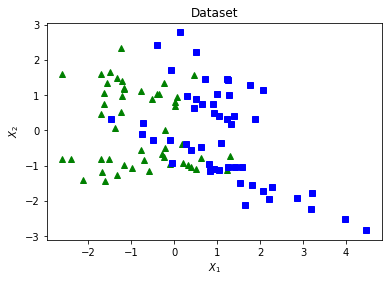

In [3]:
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")

plt.title('Dataset')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

 ## SVM

In [44]:
# Train 
svc = SVC(gamma=0.5, probability=True).fit(X_train, y_train)

# Predict
y_hat = svc.predict_proba(X_test)

y_hat[:5]

array([[0.38607424, 0.61392576],
       [0.12808689, 0.87191311],
       [0.8571604 , 0.1428396 ],
       [0.86159969, 0.13840031],
       [0.09554704, 0.90445296]])

## RandomForest

In [45]:
# Train
rf = RandomForestClassifier(n_estimators=100, random_state=41, max_features=2).fit(X_train, y_train)

# Predict
rf.predict_proba(X_test)[:5] # negative class, positive class 

array([[0.46, 0.54],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.92, 0.08],
       [0.  , 1.  ]])

## 1. Display the precision recall curve & average precision for SVM

### 1.1 Precision-recall curve

It focuses on the performance of a **classifier on the positive (minority class) only**.

Precision is the ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

A precision-recall curve is calculated by creating crisp class labels for probability predictions across a set of thresholds and calculating the precision and recall for each threshold. A line plot is created for the thresholds in ascending order with recall on the x-axis and precision on the y-axis.

If we are interested in a threshold that results in the best balance of precision and recall, then this is the same as optimizing the F-measure that summarizes the harmonic mean of both measures.

F-Measure $ = {2 * Precision * Recall \over Precision + Recall}$

In [6]:
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

precision, recall, thresholds

(array([0.61111111, 0.58823529, 0.625     , 0.66666667, 0.71428571,
        0.76923077, 0.75      , 0.81818182, 0.8       , 0.77777778,
        0.75      , 0.85714286, 0.83333333, 0.8       , 0.75      ,
        0.66666667, 0.5       , 1.        , 1.        ]),
 array([1.        , 0.90909091, 0.90909091, 0.90909091, 0.90909091,
        0.90909091, 0.81818182, 0.81818182, 0.72727273, 0.63636364,
        0.54545455, 0.54545455, 0.45454545, 0.36363636, 0.27272727,
        0.18181818, 0.09090909, 0.09090909, 0.        ]),
 array([-0.9791845 , -0.90386743, -0.8941331 , -0.85154629, -0.80827384,
        -0.66585271, -0.34734058,  0.10556372,  0.14017212,  0.38445219,
         0.61400261,  0.83953687,  0.87939757,  0.96017829,  1.0301401 ,
         1.04626156,  1.10296753,  1.11981545]))

In [7]:
# Threshold 0 is the default value
close_zero = np.argmin(thresholds)
print(f"precision[{close_zero}]: {precision[close_zero]:.2}, recall[{close_zero}]: {recall[close_zero]}")

precision[0]: 0.61, recall[0]: 1.0


In [8]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=-0.665853, F-Score=0.833


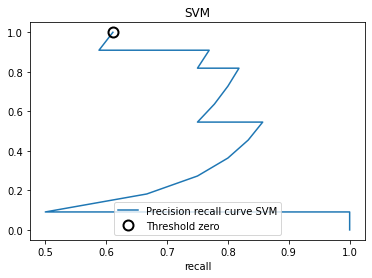

In [9]:
plt.plot(precision, recall, label="Precision recall curve SVM")
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, 
         label="Threshold zero", fillstyle="none", c='k', mew=2)

plt.title('SVM')
plt.xlabel('Precision')
plt.xlabel('recall')
plt.legend(loc="best")
plt.show()

### 1.1.1 Optimal Threshold Tuning

In [10]:
fscore = (2 * precision * recall) / (precision + recall)

fscore, np.max(fscore), f1_score(y_test, svc.predict(X_test))

(array([0.75862069, 0.71428571, 0.74074074, 0.76923077, 0.8       ,
        0.83333333, 0.7826087 , 0.81818182, 0.76190476, 0.7       ,
        0.63157895, 0.66666667, 0.58823529, 0.5       , 0.4       ,
        0.28571429, 0.15384615, 0.16666667, 0.        ]),
 0.8333333333333333,
 0.8181818181818182)

In [11]:
# apply threshold to positive probabilities to create labels
to_labels = lambda positive_probs, threshold: (positive_probs >= threshold).astype('int')

In [12]:
# evaluate each threshold
probs  = y_hat[:, 1] # Positive class only
scores = [f1_score(y_test, to_labels(probs, threshold)) for threshold in thresholds]

# threshold = 0.205 is better then 0 for SVM
np.max(scores), np.argmax(scores), thresholds[np.argmax(scores)], f1_score(y_test, svc.predict(X_test))

(0.8181818181818182, 10, 0.6140026096464748, 0.8181818181818182)

### 1.2 Average Precision 

In [49]:
ap_svc = average_precision_score(y_test, svc.predict(X_test))

print(f"Average precision: {ap_svc:.2f}")

Average precision: 0.75


## 2. Display the precision recall curve & Average precision for RandomForest

### 2.1 Precision recall curve

In [14]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])

precision_rf, recall_rf, thresholds_rf

(array([0.44      , 0.55555556, 0.58823529, 0.625     , 0.66666667,
        0.71428571, 0.76923077, 0.83333333, 0.81818182, 0.8       ,
        0.77777778, 0.75      , 0.85714286, 0.83333333, 1.        ,
        1.        , 1.        ]),
 array([1.        , 0.90909091, 0.90909091, 0.90909091, 0.90909091,
        0.90909091, 0.90909091, 0.90909091, 0.81818182, 0.72727273,
        0.63636364, 0.54545455, 0.54545455, 0.45454545, 0.45454545,
        0.36363636, 0.        ]),
 array([0.  , 0.01, 0.02, 0.05, 0.08, 0.11, 0.2 , 0.37, 0.54, 0.62, 0.67,
        0.71, 0.92, 0.94, 0.99, 1.  ]))

In [15]:
# Threshold 0.5 is the default value 
close_zero_rf = np.argmin(np.abs(thresholds_rf - 0.5))
print(f"precision[{close_zero_rf}]: {precision_rf[close_zero_rf]:.2}, recall[{close_zero_rf}]: {recall_rf[close_zero_rf]:.2}")

precision[8]: 0.82, recall[8]: 0.82


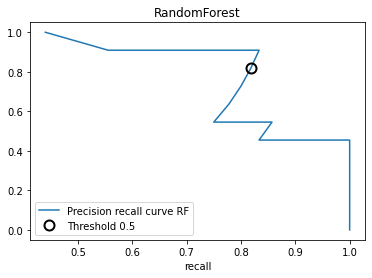

In [16]:
plt.plot(precision_rf, recall_rf, label="Precision recall curve RF")
plt.plot(precision_rf[close_zero_rf], recall_rf[close_zero_rf], 'o', markersize=10, 
         label="Threshold 0.5", fillstyle="none", c='k', mew=2)

plt.title('RandomForest')
plt.xlabel('Precision')
plt.xlabel('recall')
plt.legend(loc="best")
plt.show()

### 2.2 Average precision

In [52]:
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])

print(f"Average precision: {ap_rf:.2f}")

Average precision: 0.87


### Display the precision recall curve for RandomForest VS SVM

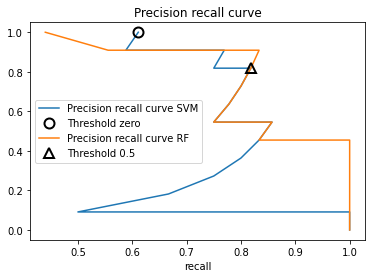

In [17]:
plt.plot(precision, recall, label="Precision recall curve SVM")
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, 
         label="Threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision_rf, recall_rf, label="Precision recall curve RF")
plt.plot(precision_rf[close_zero_rf], recall_rf[close_zero_rf], '^', markersize=10, 
         label="Threshold 0.5", fillstyle="none", c='k', mew=2)

plt.title('Precision recall curve')
plt.xlabel('Precision')
plt.xlabel('recall')
plt.legend(loc="best")
plt.show()

### Display the average precision for RandomForest VS SVM

In [59]:
ap_svc = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_rf  = average_precision_score(y_test, svc.predict(X_test))

print(f"Average precision for SVM: {ap_svc:.2f} - Accuracy for SVM: {svm.score(X_test, y_test)}")
print(f"Average precision for RF:  {ap_rf:.2f} - Accuracy for RF : {rf.score(X_test, y_test)}")

Average precision for SVM: 0.87 - Accuracy for SVM: 0.84
Average precision for RF:  0.75 - Accuracy for RF : 0.84


## 2. ROC

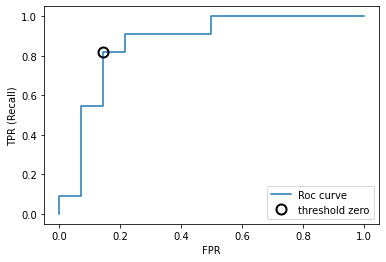

In [26]:
tfr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

close_zero = np.argmin(np.abs(thresholds))

plt.plot(tfr, tpr, label="Roc curve")
plt.plot(tfr[close_zero], tpr[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c="k", mew=2)
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.legend(loc="best")

## 3. AUC

In [42]:
for gamma in [0.01, 0.05, 0.06, 0.5, 0.9, 1.0]:
    svm      = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svm.score(X_test, y_test)
    auc      = roc_auc_score(y_test, svm.decision_function(X_test))
    
    print(f"Gamma: {gamma:.2f} - Accuracy: {accuracy:.2f} - AUC: {auc:.2f}")

Gamma: 0.01 - Accuracy: 0.76 - AUC: 0.89
Gamma: 0.05 - Accuracy: 0.80 - AUC: 0.90
Gamma: 0.06 - Accuracy: 0.80 - AUC: 0.90
Gamma: 0.50 - Accuracy: 0.84 - AUC: 0.86
Gamma: 0.90 - Accuracy: 0.84 - AUC: 0.81
Gamma: 1.00 - Accuracy: 0.84 - AUC: 0.81
